# Import

In [1]:
%load_ext autoreload
%autoreload 2
from model import Model
from data_formater import DataFormater
from one_hot_encoder import OneHotEncoder
import pandas as pd
import numpy as np
from utils import get_id_from_path, load_patient_archive, load_radiomics, load_clinical_data,plot_patient_mask, load_target_data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from lifelines import CoxPHFitter
from metrics import cindex

Using TensorFlow backend.


# Introduction  
In this notebook I will presente my apporach to the OWKIN datachallenge.  
The goal is to predict the life expentancy of cancer patients knowing features from clinical data (age, Nstage, Tstage ...) and radiomics data (glcm_Autocorrelation, shape_Compactness, shape_Maximum3DDiameter ...).  
For this approach we will not use data from 3d scan : we will consider features from radiomics as efficient to represente caracteristics of each scan. A more sophisticated idea would be to extract certain features directly from the scan using CNN (convolutional neural network).  
Here we will first preprocess our data set : 
- one hot encode categorical features  
- replace missing values  
- scale values   

Then we will try to fit different models on our data :
- Cox model
- weibull  
- linearultitask  
- SurvivalForest  
- extra_survival_trees  
- random_forest  

For each model we will compute the c-index score on a subset of the training set (called validation set)

# Exploration

With event = 1 :

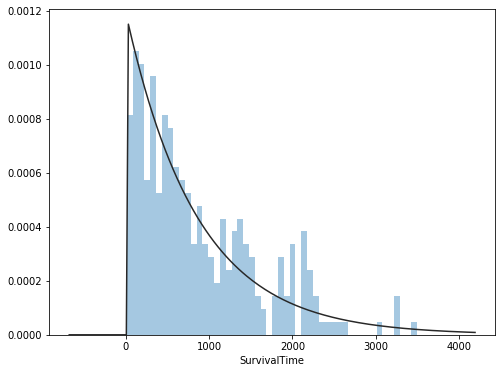

In [2]:
plt.figure(figsize=(8,6))
target_data = load_target_data('output_VSVxRFU.csv')
sns.distplot(target_data[target_data.Event<=1].SurvivalTime,fit = scipy.stats.expon, kde= False, bins= 50)

When the death is observed : the Survival time might follow an exponential law 

With event = 0 :

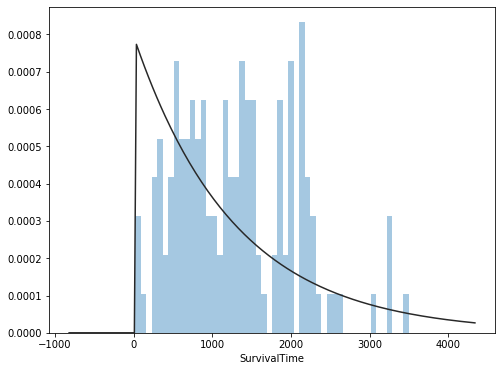

In [3]:
plt.figure(figsize=(8,6))
target_data = load_target_data('output_VSVxRFU.csv')
sns.distplot(target_data[target_data.Event==0].SurvivalTime,fit = scipy.stats.expon, kde= False, bins= 50)

# Data preparation

In [4]:
# Non-categorical columns 
other_columns = ['original_shape_Compactness1', 'original_shape_Compactness2','original_shape_Maximum3DDiameter','original_shape_SphericalDisproportion', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio','original_shape_VoxelVolume', 'original_firstorder_Energy','original_firstorder_Entropy', 'original_firstorder_Kurtosis',
       'original_firstorder_Maximum', 'original_firstorder_Mean','original_firstorder_MeanAbsoluteDeviation','original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range', 'original_firstorder_RootMeanSquared','original_firstorder_Skewness', 'original_firstorder_StandardDeviation','original_firstorder_Uniformity', 'original_firstorder_Variance',
       'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence','original_glcm_ClusterShade', 'original_glcm_ClusterTendency','original_glcm_Contrast', 'original_glcm_Correlation',
       'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceAverage','original_glcm_JointEnergy', 'original_glcm_JointEntropy','original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Imc1',
       'original_glcm_Imc2', 'original_glcm_Idmn', 'original_glcm_Idn','original_glcm_InverseVariance', 'original_glcm_MaximumProbability','original_glcm_SumAverage', 'original_glcm_SumEntropy',
       'original_glrlm_ShortRunEmphasis', 'original_glrlm_LongRunEmphasis','original_glrlm_GrayLevelNonUniformity','original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunPercentage',
       'original_glrlm_LowGrayLevelRunEmphasis','original_glrlm_HighGrayLevelRunEmphasis','original_glrlm_ShortRunLowGrayLevelEmphasis','original_glrlm_ShortRunHighGrayLevelEmphasis',
       'original_glrlm_LongRunLowGrayLevelEmphasis','original_glrlm_LongRunHighGrayLevelEmphasis', 'Mstage', 'Nstage','Tstage', 'age']

In [5]:
data_formater =DataFormater('data_train', 'data_test', 
                            'output_VSVxRFU.csv', 
                            categorical_col=['Histology','SourceDataset'], 
                            other_columns=other_columns)

## Scaling  
At  first, we will rescale all the continuous variables (all features in other_columns)  
We will use the StandardScaler from sklearn.preprocessing :
Each column will be transformed as follows :   
### $ x' = \frac{x-\mu}{\sigma}$

In [6]:
data_formater.scale_data()

## Replace NAN values  
As we can see below in the dataframe, some columns have nan values which can't be fed into a machine learning model.  
To solve this problem we can :  
- drop rows with nan values (but we will lose almost 10% of our data set)
- replace nan values by the mean value of the column (or the most frequent value for categorical features)
- create an ML model which can predict the missing value using all other values in the data frame 

I chose to process with the 3rd proposition  
To do that I used a package from sklearn which can create this machine learning model  
see https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

In [7]:
train_, test_, target_  = data_formater.get_data()

In [8]:
# exmaple of nan values in train set :
train_[['Histology', 'age']].loc[388]

Histology    NaN
age          NaN
Name: 388, dtype: object

## One  hot encoding  
The onehotencode_categorical_columns() method will replace nan values by their most likely value and then will replace categorical columns by their one-hot-encoding version 

In [9]:
data_formater.onehotencode_categorical_columns()

In [10]:
train, test, target = data_formater.get_data()

We split our data set into two parts (one for training one for validation) :

In [11]:
validation = train.iloc[0:50]
train=train.iloc[50:300]
test= test
target_train = target.iloc[50:300]
target_validation = target.iloc[0:50]

# Correlation matrix  
We plot the absolute correlation between all variables and SurvivalTime :  
(we drop the column "l1" from the training data set because we have the information of "is l1" into "is not l2" )

In [12]:
corr  = pd.concat([train, target_train], axis =1).corr().abs()['SurvivalTime'].sort_values(kind="quicksort", ascending =False).head(57).drop('Event').drop('l1')
corr.head(10)

SurvivalTime                       1.000000
l2                                 0.520955
original_glcm_Idn                  0.452836
original_glcm_Idmn                 0.442176
original_glcm_Correlation          0.408242
original_glcm_Id                   0.407311
original_glcm_Idm                  0.405498
original_glcm_Imc1                 0.399725
original_glrlm_RunPercentage       0.398963
original_glcm_DifferenceAverage    0.395099
Name: SurvivalTime, dtype: float64

In [13]:
most_correlated = corr.index.values

# Models  
I will compare several models from the pysurvival package and lifelines package  
I will train the model on a subset of the training data set (with 250 rows on 300)  
And then compute the C-index metrics on the 100 remaining rows

### 1) cox_model

In [14]:
model_cox =  Model('cox')
model_cox.build_cox()
model_cox.train(train, target_train)

In [15]:
print('c-index validation = ',model_cox.c_index(validation,target_validation))
prediction = model_cox.predict_and_format(test, 'cox.csv')
print('c-index train = ',model_cox.c_index(train, target_train))

c-index validation =  0.5501691093511819
c-index train =  0.7457308977701114


#### Survival curves :  
Here we plot some survival functions for some patients of the test set  
Survival function means the probability of being alive at time t  
$ P(Event>t) $

Text(0, 0.5, '$ P(Event>t)$')

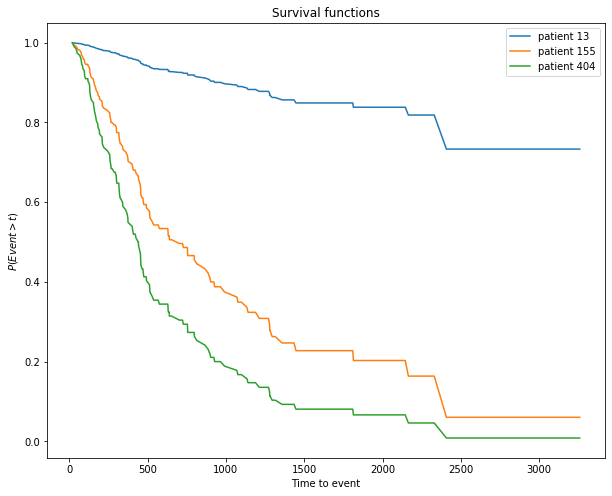

In [16]:
plt.figure(figsize=(10,8))
time = model_cox.model.predict_survival_function(test).index.values
plt.plot(time,model_cox.model.predict_survival_function(test)[[13,155,404]].values)
plt.legend(['patient 13','patient 155', 'patient 404' ])

plt.title('Survival functions')
plt.xlabel('Time to event')
plt.ylabel('$ P(Event>t)$')

This type of curve show us that patient n°13 has a better life expectancy than patient 155 and 404

### 2) weibull_model

In [17]:
model_weibull =  Model('exp regression')
model_weibull.build_weibullAFT()
model_weibull.train(train, target_train)

In [18]:
c_index_val = model_weibull.c_index(validation,target_validation)
c_index_train = model_weibull.c_index(train,target_train)
print('c-index validation = ', c_index_val)
print('c-index train = ',c_index_train)

c-index validation =  0.6775648252460252
c-index train =  0.730897770452442


### 3) log_normal_model

In [19]:
model_logNormal =  Model('logNormal')
model_logNormal.build_logNormal()
model_logNormal.train(train, target_train)

In [20]:
c_index_val = model_logNormal.c_index(validation,target_validation)
c_index_train = model_logNormal.c_index(train, target_train)
print('c-index validation = ', c_index_val)
print('c-index train = ',c_index_train)

c-index validation =  0.6595264937918881
c-index train =  0.7332326145672603


### 4) linear_multi_task_model

In [21]:
model_linearultitask = Model('multi_task')
model_linearultitask.build_multitask()
model_linearultitask.train(train,target_train)

% Completion: 100%|***********************************************|Loss: 469.32


In [22]:
c_index_val = model_linearultitask.c_index(validation,target_validation)
c_index_train = model_linearultitask.c_index(train,target_train)
print('c-index validation = ', c_index_val)
print('c-index train = ',c_index_train)

c-index validation =  0.649379932348936
c-index train =  0.7279219887374775


### 5) conditional_survival_forest_model

In [23]:
model_SurvivalForest = Model('conditional_forest')
model_SurvivalForest.build_forest()
model_SurvivalForest.train(train,target_train)

In [24]:
c_index_val = model_SurvivalForest.c_index(validation,target_validation)
c_index_train = model_SurvivalForest.c_index(train,target_train)
print('c-index validation = ', c_index_val)
print('c-index train = ',c_index_train)

c-index validation =  0.6922209695525116
c-index train =  0.739275740511496


### 6 ) survival_trees_model

In [25]:
model_extra_survival_trees = Model('survival_trees')
model_extra_survival_trees.build_extra_survival_trees()
model_extra_survival_trees.train(train,target_train)

In [26]:
c_index_val = model_extra_survival_trees.c_index(validation,target_validation)
c_index_train = model_extra_survival_trees.c_index(train,target_train)
print('c-index validation = ', c_index_val)
print('c-index train = ',c_index_train)

c-index validation =  0.714768883870183
c-index train =  0.7426635535408402


### 7) random_forest_model

In [27]:
model_random_forest = Model('1st model')
model_random_forest.build_random_forest()
model_random_forest.train(train,target_train)

In [28]:
c_index_val = model_random_forest.c_index(validation,target_validation)
c_index_train = model_random_forest.c_index(train,target_train)
print('c-index validation = ', c_index_val)
print('c-index train = ',c_index_train)

c-index validation =  0.7192784667337173
c-index train =  0.763494025545592


The random forest model has a better score, we will continue our work with this one.  

## Features selection  
For each feature, we train a model which only takes this feature as input and computes the c-index value on the training set. Once it's done, we classify features in descending order for their associated c-index score  

To train our model with best features we will select a subset of the total number of features based on their score for c-index

In [29]:
scores_random_forest = model_random_forest.fit_and_score(train, target_train)
scores_random_forest

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


original_glrlm_RunPercentage                   0.706061
original_glrlm_LongRunHighGrayLevelEmphasis    0.703086
original_glrlm_LongRunEmphasis                 0.696218
original_glrlm_ShortRunEmphasis                0.695967
original_glcm_JointEnergy                      0.689466
                                                 ...   
large cell                                     0.534290
nos                                            0.524997
squamous cell carcinoma                        0.520853
nsclc nos (not otherwise specified)            0.500000
Mstage                                         0.500000
Length: 64, dtype: float64

Then we will select the top k best features and then recompute the c-index score for each k :

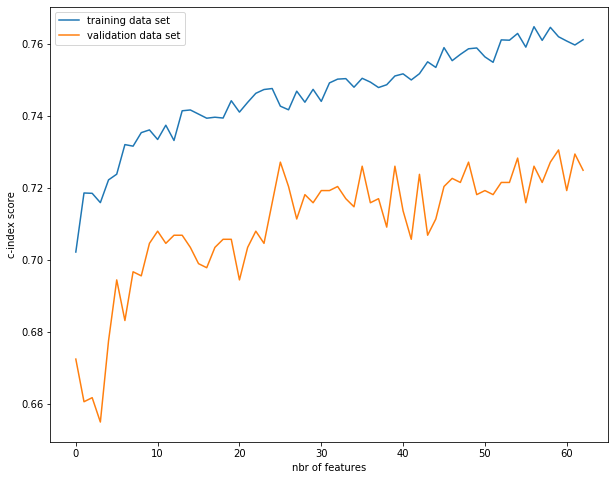

In [30]:
scores_nbr_features_train =[]
scores_nbr_features_val =[]
for i in range(1,len(scores_random_forest)):
    selected_features = scores_random_forest.head(i).index.values
    model_random_forest = Model('1st model')
    model_random_forest.build_random_forest()
    model_random_forest.train(train[selected_features],target_train)
    c_index_val = model_random_forest.c_index(validation[selected_features],target_validation)
    c_index_train = model_random_forest.c_index(train[selected_features],target_train)
    scores_nbr_features_train.append(c_index_train)
    scores_nbr_features_val.append(c_index_val)

plt.figure(figsize=(10,8))
plt.plot(scores_nbr_features_train, label = 'training data set')
plt.plot(scores_nbr_features_val, label ='validation data set')
plt.ylabel('c-index score')
plt.xlabel('nbr of features')
plt.legend()

## Retrain the model on the full data set  
We will retrain the random forest model on the full data set and compute the output for the test set

In [31]:
train, test, target = data_formater.get_data()
print('train data set shape : ', train.shape)
print('test data set shape : ',test.shape)

train data set shape :  (300, 64)
test data set shape :  (125, 64)


In [32]:
model_random_forest = Model('1st model')
model_random_forest.build_random_forest(500)
model_random_forest.train(train,target)

In [33]:
c_index_train = model_random_forest.c_index(train,target)
print('c-index train = ',c_index_train)

c-index train =  0.7667046317385577


## Create prediction 

In [34]:
Y_prediction = model_random_forest.predict_expectation(test)
if 'pysurvival' in str(type(model_random_forest.model)):
    Y_prediction = 10 * max(Y_prediction) - Y_prediction
    Y_prediction = pd.DataFrame(Y_prediction, index=test.index,
                                columns=['SurvivalTime'])

Y_prediction['Event'] = np.nan
Y_prediction.to_csv('prediction_random_forest.csv')

## Future work  
Model : 
- Here we have done a benchmark of different approaches to a lifetime expectation value problem.  
Recent research on that field proposes deep learning algorithms for this problem.  
As a future work on this subject, we could think about an implementation of these new techniques, it would be interesting to see how do these techniques improve our predictions  


Features :
- For this approach, we used preprocessed features from  'radionomics.csv' and 'clinical_data.csv' files. For another approach we could think about doing a feature extraction from 3d images, using, for example, 3d convolutional neural network. These features could bring information about the microscopic aspect of each image while information from radionomics.csv are more focused on the macroscopic aspect of the tumour

## References 

[1] lifelines package documentation : https://lifelines.readthedocs.io/en/latest/  
[2] pysurvival package documentation : https://square.github.io/pysurvival/  
[3] sklearn for missing values prediction : https://scikit-learn.org/stable/modules/impute.html   
[4] Cox, David R. "Regression models and life‐tables." Journal of the Royal Statistical Society: Series B (Methodological) 34.2 (1972): 187-202.  
[5] Shahrbanoo Goli,1 Hossein Mahjub. Survival Prediction and Feature Selection in Patients with Breast Cancer Using Support Vector Regression  
[6] Ishwaran H, Kogalur U, Blackstone E, Lauer M. Random survival forests. The Annals of Applied Statistics. 2008; 2(3):841–860.  
[7] Ching T, Zhu X, and Garmire LX, Cox-nnet: an artificial neural network method for prognosis prediction of high-throughput omics data (2018), PLOS Computational Biology